<a href="https://colab.research.google.com/github/Ale613/Big-Data-Experiments/blob/main/BD_Experiment_with_french_dataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz

--2025-03-06 09:50:52--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M  17.2MB/s    in 23s     

2025-03-06 09:51:16 (16.4 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]



In [4]:
!tar xf spark-3.5.5-bin-hadoop3.tgz

In [5]:
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [7]:
import findspark
findspark.init()

In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

In [10]:
# Creazione Spark Session
spark = SparkSession.builder.appName("EmotionRecognition") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [11]:
# Caricamento del dataset Allociné
dataset = load_dataset("tblard/allocine")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.31k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/60.0M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.58M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/7.58M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [12]:
# Unione train e validation per avere più dati di addestramento
df_train = spark.createDataFrame(dataset['train'])
df_test = spark.createDataFrame(dataset['test'])
df_train = df_train.union(spark.createDataFrame(dataset['validation']))

df_train = df_train.repartition(100)  # Dividere il dataset in più partizioni
df_test = df_test.repartition(50)

In [13]:
# Pulizia del testo
def clean_text(df):
    df = df.withColumn("review", lower(col("review")))
    df = df.withColumn("review", regexp_replace(col("review"), "[^a-zA-Z ]", ""))
    return df

df_train = clean_text(df_train)
df_test = clean_text(df_test)

In [14]:
# Label encoding
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
label_indexer_model = label_indexer.fit(df_train)
df_train = label_indexer_model.transform(df_train)
df_test = label_indexer_model.transform(df_test)

In [15]:
# Tokenizzazione e rimozione stopwords
tokenizer = Tokenizer(inputCol="review", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

df_train = tokenizer.transform(df_train)
df_test = tokenizer.transform(df_test)
df_train = stopwords_remover.transform(df_train)
df_test = stopwords_remover.transform(df_test)

In [16]:
# Feature extraction con TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=2000)
idf = IDF(inputCol="raw_features", outputCol="features")

df_train = hashingTF.transform(df_train)
df_test = hashingTF.transform(df_test)
idf_model = idf.fit(df_train)
df_train = idf_model.transform(df_train)
df_test = idf_model.transform(df_test)

In [17]:
# Definizione dei modelli
models = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="label_index"),
    "Naive Bayes": NaiveBayes(featuresCol="features", labelCol="label_index"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label_index"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="label_index")
}

In [18]:
# Parametri per il tuning
param_grid = {
    "Logistic Regression": ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.1, 0.01, 0.001]).build(),
    "Naive Bayes": ParamGridBuilder().addGrid(NaiveBayes.smoothing, [1.0, 1.5]).build(),
    "Random Forest": ParamGridBuilder().addGrid(RandomForestClassifier.numTrees, [10, 50, 100]).build(),
    "Decision Tree": ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15]).build()
}

In [19]:
# Cross-validation
cross_validators = {}
for model_name, model in models.items():
    param_grid_for_model = param_grid[model_name]
    evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid_for_model, evaluator=evaluator, numFolds=3)
    cross_validators[model_name] = crossval

In [20]:
# Addestramento e valutazione
metrics = {"accuracy": {}, "weightedPrecision": {}, "weightedRecall": {}, "f1": {}}
for name, crossval in cross_validators.items():
    cv_model = crossval.fit(df_train)
    predictions = cv_model.transform(df_test)
    for metric in metrics.keys():
        evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName=metric)
        metrics[metric][name] = evaluator.evaluate(predictions)
        print(f"{metric.capitalize()} del modello {name}: {metrics[metric][name]}")

Accuracy del modello Logistic Regression: 0.8655
Weightedprecision del modello Logistic Regression: 0.8654912907347738
Weightedrecall del modello Logistic Regression: 0.8654999999999999
F1 del modello Logistic Regression: 0.8654949434221675
Accuracy del modello Naive Bayes: 0.8374
Weightedprecision del modello Naive Bayes: 0.8373673505588035
Weightedrecall del modello Naive Bayes: 0.8373999999999999
F1 del modello Naive Bayes: 0.8373618566051142
Accuracy del modello Random Forest: 0.7377
Weightedprecision del modello Random Forest: 0.7384668138903785
Weightedrecall del modello Random Forest: 0.7377
F1 del modello Random Forest: 0.7367947310088145
Accuracy del modello Decision Tree: 0.6604
Weightedprecision del modello Decision Tree: 0.6685584179964323
Weightedrecall del modello Decision Tree: 0.6604
F1 del modello Decision Tree: 0.6525028203986744


In [21]:
# Uso del modello pre-addestrato di Hugging Face
from transformers import pipeline
classifier = pipeline("text-classification", model="alosof/camembert-sentiment-allocine")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/443M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at alosof/camembert-sentiment-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

Device set to use 0


In [22]:
# Conversione test set a Pandas per Hugging Face
test_data = df_test.select("review", "label").toPandas()

In [23]:
label_mapping = {
    "LABEL_0": 0,
    "LABEL_1": 1,
}

In [24]:
def predict_sentiment(text):
    result = classifier(text)
    label = result[0]['label']
    mapped_label = label_mapping.get(label, "unknown")
    return mapped_label

In [25]:
# Applica il modello Hugging Face ai dati di test
test_data["hf_prediction"] = test_data["review"].apply(predict_sentiment)

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calcola accuracy
hf_accuracy = accuracy_score(test_data["label"], test_data["hf_prediction"])

# Precision, Recall, F1-score
hf_precision, hf_recall, hf_f1, _ = precision_recall_fscore_support(
    test_data["label"], test_data["hf_prediction"], average="weighted")

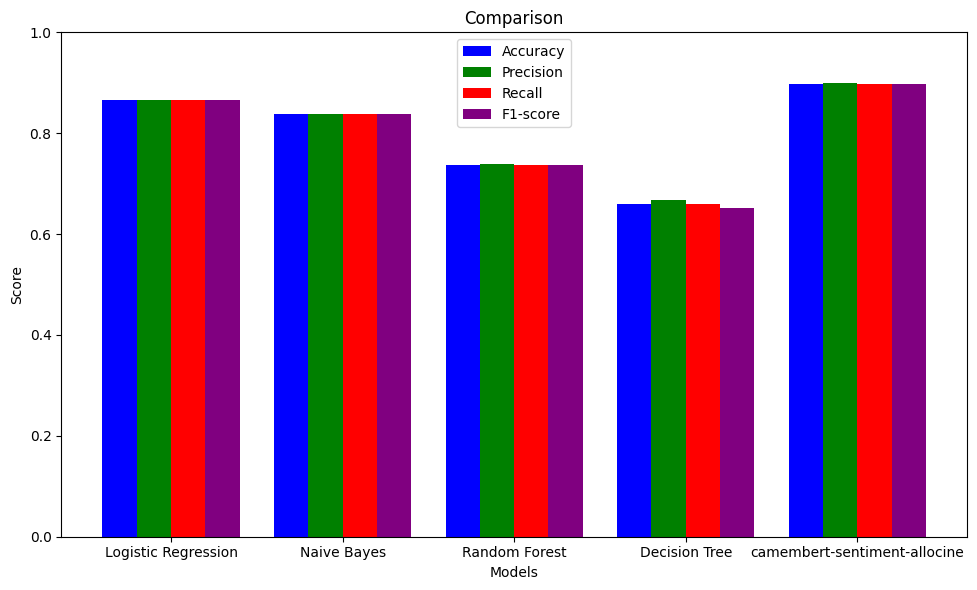

In [27]:
# Dati per il grafico
labels = list(models.keys())
labels.append("camembert-sentiment-allocine")
metrics["accuracy"]["camembert-sentiment-allocine"] = hf_accuracy
metrics["weightedPrecision"]["camembert-sentiment-allocine"] = hf_precision
metrics["weightedRecall"]["camembert-sentiment-allocine"] = hf_recall
metrics["f1"]["camembert-sentiment-allocine"] = hf_f1

# Grafico
bar_width = 0.2
index = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(index - 1.5 * bar_width, [metrics["accuracy"][m] for m in labels], bar_width, label="Accuracy", color='blue')
ax.bar(index - 0.5 * bar_width, [metrics["weightedPrecision"][m] for m in labels], bar_width, label="Precision", color='green')
ax.bar(index + 0.5 * bar_width, [metrics["weightedRecall"][m] for m in labels], bar_width, label="Recall", color='red')
ax.bar(index + 1.5 * bar_width, [metrics["f1"][m] for m in labels], bar_width, label="F1-score", color='purple')
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison")
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()